# **imports**

In [6]:
%load_ext autoreload
%autoreload 2

In [77]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import pandas as pd
import scipy.optimize as optimize


In [51]:
import os
import sys
sys.path.append("../")

from modules.utils import load_json, get_pooled_IPL_positions, get_template, get_interpolated_templates, get_downsampled_data
from modules.preprocessing import pool_avg_traces, get_baseline_subtracted_traces
from modules.masking import get_masked_traces
from modules.model import get_cone_tunings

In [3]:
plt.rcParams["figure.autolayout"] = True

# **load data**

In [40]:
qc = 0.35 # quality criterion to evaluate traces
std_qc = 1
nLEDs = 6 # number of LEDs used in a given experiment
fpath_expinfo = r'../experiment_info/zf_leds_for_analysis.json'
led_nms = load_json(fpath_expinfo)

In [18]:
# get average traces
fpath_control = r"D:\Project_with_Chiara\analysis_clean\data\control"
fpath_red = r"D:\Project_with_Chiara\analysis_clean\data\red"
fpath_green = r"D:\Project_with_Chiara\analysis_clean\data\green"
fpath_blue = r"D:\Project_with_Chiara\analysis_clean\data\blue"
fpath_uv = r"D:\Project_with_Chiara\analysis_clean\data\uv"


pooled_traces_control, pooled_triggerstamps_control, pooled_ticks_control, pooled_baselines_control, pooled_quality_criterion_control = pool_avg_traces(fpath_control, fpath_expinfo, nLEDs)
pooled_traces_bs_control = get_baseline_subtracted_traces(pooled_traces_control, pooled_baselines_control, snippets=False)

pooled_traces_red, pooled_triggerstamps_red, pooled_ticks_red, pooled_baselines_red, pooled_quality_criterion_red = pool_avg_traces(fpath_red, fpath_expinfo, nLEDs)
pooled_traces_bs_red = get_baseline_subtracted_traces(pooled_traces_red, pooled_baselines_red, snippets=False)

pooled_traces_green, pooled_triggerstamps_green, pooled_ticks_green, pooled_baselines_green, pooled_quality_criterion_green = pool_avg_traces(fpath_green, fpath_expinfo, nLEDs)
pooled_traces_bs_green = get_baseline_subtracted_traces(pooled_traces_green, pooled_baselines_green, snippets=False)

pooled_traces_blue, pooled_triggerstamps_blue, pooled_ticks_blue, pooled_baselines_blue, pooled_quality_criterion_blue = pool_avg_traces(fpath_blue, fpath_expinfo, nLEDs)
pooled_traces_bs_blue = get_baseline_subtracted_traces(pooled_traces_blue, pooled_baselines_blue, snippets=False)

pooled_traces_uv, pooled_triggerstamps_uv, pooled_ticks_uv, pooled_baselines_uv, pooled_quality_criterion_uv = pool_avg_traces(fpath_uv, fpath_expinfo, nLEDs)
pooled_traces_bs_uv = get_baseline_subtracted_traces(pooled_traces_uv, pooled_baselines_uv, snippets=False)

14it [00:09,  1.41it/s]


final shape of pooled traces: 1917 rois | 18000  time points


15it [00:09,  1.58it/s]


final shape of pooled traces: 2238 rois | 18000  time points


8it [00:04,  1.84it/s]


final shape of pooled traces: 1039 rois | 18000  time points


9it [00:04,  1.95it/s]


final shape of pooled traces: 1045 rois | 18000  time points


14it [00:09,  1.46it/s]

final shape of pooled traces: 2058 rois | 18000  time points


In [17]:
# get the IPL positions and the regions of the rois
pooled_IPLs_control, pooled_regions_control = get_pooled_IPL_positions(fpath_control)
pooled_IPLs_uv, pooled_regions_uv = get_pooled_IPL_positions(fpath_uv)
pooled_IPLs_green, pooled_regions_green = get_pooled_IPL_positions(fpath_green)
pooled_IPLs_red, pooled_regions_red = get_pooled_IPL_positions(fpath_red)
pooled_IPLs_blue, pooled_regions_blue = get_pooled_IPL_positions(fpath_blue)

0it [00:00, ?it/s]

final shape of pooled IPL positions: 1917 rois


0it [00:00, ?it/s]

final shape of pooled IPL positions: 2058 rois


0it [00:00, ?it/s]

final shape of pooled IPL positions: 1039 rois


0it [00:00, ?it/s]

final shape of pooled IPL positions: 2238 rois


0it [00:00, ?it/s]

final shape of pooled IPL positions: 1045 rois


# **template matching**

## **get templates**

In [35]:
# get the template
ticks_per_template = 200
path_to_template = r"..\experiment_info\model\fitting_templates.mat"
templates = get_template(path_to_template, temp_type='3s')
templates = get_interpolated_templates(templates, num_of_ds_ticks=ticks_per_template)

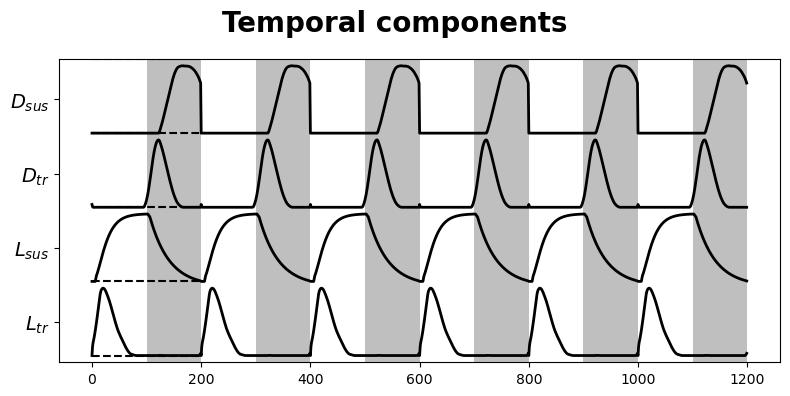

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
temp_labels = [r'$L_{tr}$', r'$L_{sus}$', r'$D_{tr}$', r'$D_{sus}$']
fig.suptitle('Temporal components', fontsize=20, fontweight='bold')
expand_templates = np.zeros((nLEDs*templates.shape[0], templates.shape[1]))
for i in range(nLEDs):
    expand_templates[i*templates.shape[0]:(i+1)*templates.shape[0]] = templates
    
    
for i in range(templates.shape[1]):
    ax.plot(expand_templates[:, i] + i*1.1, 'k', lw=2)
# ax.vlines(100, -0.1, 4.1, ls='--', lw = 2, color='k')
for i in range(nLEDs):
    ax.axvspan(ticks_per_template*i+ticks_per_template/2, ticks_per_template*i+ticks_per_template, 0, 4.1, facecolor='gray', alpha=0.5)
    ax.hlines(i*1.1, 0, templates.shape[0], 'k', '--')

ax.yaxis.set_ticks([i*1.1+0.5 for i in range(templates.shape[1])], temp_labels, fontsize=14)
ax.set_ylim(-0.1, 4.4)
plt.tight_layout()

## **downsample traces**

In [38]:
# downsample data
ticks_to_interpolate = ticks_per_template * nLEDs
traces_ds_control = get_downsampled_data(pooled_traces_bs_control, ticks_to_interpolate)
traces_ds_uv = get_downsampled_data(pooled_traces_bs_uv, ticks_to_interpolate)
traces_ds_green = get_downsampled_data(pooled_traces_bs_green, ticks_to_interpolate)
traces_ds_red = get_downsampled_data(pooled_traces_bs_red, ticks_to_interpolate)
traces_ds_blue = get_downsampled_data(pooled_traces_bs_blue, ticks_to_interpolate)

In [42]:
# mask data
traces_ds_control = get_masked_traces(traces_ds_control, pooled_quality_criterion_control, qc=qc, IPL_positions=pooled_IPLs_control, std_qc=std_qc)
traces_ds_uv = get_masked_traces(traces_ds_uv, pooled_quality_criterion_uv, qc=qc, IPL_positions=pooled_IPLs_uv, std_qc=std_qc)
traces_ds_green = get_masked_traces(traces_ds_green, pooled_quality_criterion_green, qc=qc, IPL_positions=pooled_IPLs_green, std_qc=std_qc)
traces_ds_red = get_masked_traces(traces_ds_red, pooled_quality_criterion_red, qc=qc, IPL_positions=pooled_IPLs_red, std_qc=std_qc)
traces_ds_blue = get_masked_traces(traces_ds_blue, pooled_quality_criterion_blue, qc=qc, IPL_positions=pooled_IPLs_blue, std_qc=std_qc)

## **get cone tuning curves**

In [56]:
path_to_cone_data = r"..\experiment_info\model\cone_data.csv"
cone_tunings = get_cone_tunings(path_to_cone_data, N_ticks_extra=templates.shape[0])

## **get log opsin tuning curves**

In [65]:
def optimizing_fun(params, x, data, return_fit=False):
    """
    Applies linear transformation on log(x+c) and normalizes to have max 1

    Parameters
    ----------
    params : tuple of floats
        (a, b, c_log) parameters of the linear transformation
    x : array-like
        input values
    data : array-like
        target values
    return_fit : bool, optional
        if True, returns the fit values in addition to the mean squared error

    Returns
    -------
    mse : float
        mean squared error between the fit and the data
    fit : array-like, optional
        fit values
    """
    a,b,c_log=params
    # scale the input values
    fit = a*np.log(x+c_log)+b
    # normalize to have max 1
    fit = fit/np.max(fit)
    # calculate the mean squared error between the fit and the data
    mse = np.mean((fit-data)**2)
    if return_fit:
        return fit, mse
    else:
        return mse

In [72]:
def get_opsin_data():
    """
    read opsin data
    (excel file)
    """
    fpath_expinfo = r'../experiment_info/zf_leds_for_analysis.json'
    led_nms = load_json(fpath_expinfo)
    
    led_nms_num = np.array([int(led) for led in led_nms]) # numerical values of the LED wavelengths [nm]
    min_led = np.min(led_nms_num)
    max_led = np.max(led_nms_num)
    
    filepath = r"..\experiment_info\model\LED_opsin_data.xlsx"
    opsin_df = pd.read_excel (filepath, header =0 )#[::-1]
    opsins =["R", "G", "B", "U"]
    experimental_wvs = opsin_df['wavelength'].between(min_led, max_led) # indices
    return opsins, experimental_wvs, opsin_df

In [73]:
def get_log_opsin_data():
    # get the log opsin tuning curves (from Takeshi's paper)
    opsins, experimental_wvs, opsin_df = get_opsin_data()

    """
    read LED data
    (excel file)
    """
    filepath = r"..\experiment_info\model\LED wavelength.xlsx"
    led_df = pd.read_excel (filepath, header =0 )#[::-1]

    """
    read hc_block data
    """
    opsins_data = []
    filepaths = [r"..\experiment_info\model\%s-Cone recordings - HCblock.xlsx" % opsin for opsin in opsins]
    for path in filepaths:
        if not os.path.exists(path):
            raise ValueError("File not found: %s" % path)
        else:
            opsins_data.append(pd.read_excel (path, header=0))
    # merge dfs
    hc_block_df = pd.concat(opsins_data, ignore_index=True)
    
    return hc_block_df, opsins, experimental_wvs, led_df, opsin_df

In [74]:
def get_log_opsin_tunings():
    """
    optimize parameters for all cones
    """
    hc_block_df, opsins, experimental_wvs, led_df, opsin_df = get_log_opsin_data()
    
    res_all = []
    fit_all = []
    mse_all = []
    data = []

    for cone_type in opsins:
        
        #compute mean control traces and interpolate to opsin wavelength
        wavelength = led_df[:13]['Wavelength'].values[::-1]
        data = hc_block_df[hc_block_df['cone_type']==cone_type].loc[:, hc_block_df.columns != 'cone_type'].mean(axis=0).values[::-1]
        data = data/np.max(data)
        
        opsin = opsin_df[(opsin_df['wavelength']>=360)&(opsin_df['wavelength']<=655) ][cone_type].values
        
        wavelength_interp = np.arange(360,656)
    
        data_interp = interp.interpolate.interp1d(wavelength,data)(wavelength_interp) 
        
        
    
        # minimize mse
        res = optimize.minimize(optimizing_fun, x0=[0.5,2,0.1], 
                                    args=(opsin, data_interp),
                                bounds=((0,10),(0,10),(0,10)))
        
        # extract results
        fit, mse = optimizing_fun(res.x,opsin, data_interp, return_fit=True )
        res_all.append(res)
        fit_all.append(fit)
        mse_all.append(mse)

    """
    put into dataframe
    """
    log_opsin_tunings = pd.DataFrame(wavelength_interp, columns=['wavelength'])
    for i, cone_type in enumerate(opsins):

        log_opsin_tunings[cone_type] =  fit_all[i]
        
    return log_opsin_tunings

In [78]:
log_opsin_tuning = get_log_opsin_tunings()

C:\Users\kozaj\AppData\Local\Temp\ipykernel_32820\2428195727.py:23: DeprecationWarning: Please use `interp1d` from the `scipy.interpolate` namespace, the `scipy.interpolate.interpolate` namespace is deprecated.
  data_interp = interp.interpolate.interp1d(wavelength,data)(wavelength_interp)
